In [122]:
import librosa
import pandas as pd
import torch
import torch.nn as nn
import glob
import numpy as np
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from scipy.stats import pearsonr
from sklearn.metrics import mean_squared_error
import random
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt

For tomorrow:

3. save the best state of the model
4. produce graphs showing valence and arousal mappings preds vs true
5. apply the model to covers1000
6. analyze the results of covers1000 keeping in mind # of covers per song, first release year

In [3]:
def get_song_level_predictions():

    anno_1_2000 = pd.read_csv("DEAM_Dataset/DEAM_Annotations/annotations/annotations averaged per song/song_level/static_annotations_averaged_songs_1_2000.csv")
    anno_2001_2058 = pd.read_csv("DEAM_Dataset/DEAM_Annotations/annotations/annotations averaged per song/song_level/static_annotations_averaged_songs_2000_2058.csv")

    annotations = pd.concat([anno_1_2000, anno_2001_2058])
    
    annotations = annotations.rename(columns={column: column.replace(" ", "") for column in annotations.columns})

    annotations['song_id'] = annotations['song_id'].astype(str)
    annotations = annotations.drop(columns=[column for column in annotations.columns if column not in ["song_id", "valence_mean", "arousal_mean"]])
    annotations['valence_mean'] = ((annotations['valence_mean'] - 1) / (9 - 1)) * (1 - (-1)) + (-1)
    annotations['arousal_mean'] = ((annotations['arousal_mean'] - 1) / (9 - 1)) * (1 - (-1)) + (-1)

    return annotations

In [4]:
annotations = get_song_level_predictions()
annotations.head()

,song_id,valence_mean,arousal_mean
0,2,-0.475,-0.500
1,3,-0.375,-0.425
2,4,0.175,0.125
3,5,-0.150,0.075
4,7,0.200,0.350


In [5]:
def get_mfcc_from_audio(file):

    y, sr = librosa.load(file)

    mfcc_matrix = librosa.feature.mfcc(
        y=y,
        sr=sr,
        n_mfcc=20
    )

    mfcc_matrix = torch.tensor(mfcc_matrix, dtype=torch.float32)
    mean = mfcc_matrix.mean(dim=1)
    std = mfcc_matrix.std(dim=1)
    min_ = mfcc_matrix.min(dim=1).values
    max_ = mfcc_matrix.max(dim=1).values
    X = torch.cat([mean, std, min_, max_], dim = 0)

    return X

In [6]:
def get_cens_from_audio(file):
    y, sr = librosa.load(file)

    chroma_matrix = librosa.feature.chroma_cens(
        y=y,
        sr=sr,
        n_chroma=12
    )

    chroma_matrix = torch.tensor(chroma_matrix, dtype=torch.float32)
    mean = chroma_matrix.mean(dim=1)
    std = chroma_matrix.std(dim=1)
    min_ = chroma_matrix.min(dim=1).values
    max_ = chroma_matrix.max(dim=1).values
    X = torch.cat([mean, std, min_, max_], dim = 0)

    return X



In [ ]:
def create_mfcc_tensor():

    audio_dir = sorted(glob.glob("DEAM_Dataset/DEAM_audio/MEMD_audio/*.mp3", recursive=True))
    X = []

    for song in tqdm(audio_dir, total=len(audio_dir)):
        mfcc_tensor = get_mfcc_from_audio(song)
        reshaped = mfcc_tensor.view(1, -1)
        X.append(reshaped)
    
    X = torch.stack(X)
    return X

In [ ]:
X = create_mfcc_tensor()

100%|██████████| 1802/1802 [05:02<00:00,  5.95it/s]


In [16]:
print(X.shape)

torch.Size([1802, 80])


In [33]:
def create_dual_feature_tensor():

    audio_dir = sorted(glob.glob("DEAM_Dataset/DEAM_audio/MEMD_audio/*.mp3", recursive=True))
    
    X = []

    for song in tqdm(audio_dir, total=len(audio_dir)):
        mfcc_tensor = get_mfcc_from_audio(song)
        cens_tensor = get_cens_from_audio(song)
        reshaped = torch.cat([mfcc_tensor, cens_tensor], dim=0)
        X.append(reshaped)
    
    X = torch.stack(X)
    return X

In [34]:
X_two = create_dual_feature_tensor()

100%|██████████| 1802/1802 [17:57<00:00,  1.67it/s]


In [35]:
print(X_two.shape)

torch.Size([1802, 128])


In [147]:
def create_label_tensor(annotations_df):
    valence = annotations_df['valence_mean'].to_numpy().astype(np.float32)
    valence = torch.from_numpy(valence).view(-1,1)

    arousal = annotations_df['arousal_mean'].to_numpy().astype(np.float32)
    arousal = torch.from_numpy(arousal).view(-1,1)

    return torch.concat((valence, arousal), dim=1)

In [148]:
y = create_label_tensor(annotations.sort_values(by='song_id'))

In [149]:
def check_dataset_creation(annotations_df, songs):

    for (_, row), song in zip(annotations_df.iterrows(), songs):
        assert row["song_id"] == song[song.rindex("/") + 1: song.index(".")]
        assert row["valence_mean"] > -1 and row["valence_mean"] < 1
        assert row["arousal_mean"] > -1 and row["arousal_mean"] < 1

In [150]:
audio_dir = sorted(glob.glob("DEAM_Dataset/DEAM_audio/MEMD_audio/*.mp3", recursive=True))

check_dataset_creation(annotations.sort_values(by='song_id'), audio_dir)

In [47]:
class EmotionRegressor(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 2)
        )

    def forward(self, x):
        return self.net(x)

In [ ]:
def concordance_cc(y_pred, y_true):
    y_true = np.asarray(y_true)
    y_pred = np.asarray(y_pred)

    mean_true = np.mean(y_true)
    mean_pred = np.mean(y_pred)

    var_true = np.var(y_true)
    var_pred = np.var(y_pred)

    covariance = np.mean((y_true - mean_true) * (y_pred - mean_pred))

    ccc = (2 * covariance) / (
        var_true + var_pred + (mean_true - mean_pred) ** 2
    )

    return ccc

In [177]:
def training_pass(X, y, lr, epochs, n_splits):

    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

    fold_results = []

    lowest_ccc = float("inf")

    for fold, (train_idx, test_idx) in enumerate(kf.split(X), 1):
        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]

        mean = X_train.mean(dim=0)
        std = X_train.std(dim=0) + 1e-8

        X_train = (X_train - mean) / std
        X_test = (X_test - mean) / std

        model = EmotionRegressor(input_dim=X.shape[1])
        criterion = nn.MSELoss()
        optimizer = torch.optim.Adam(model.parameters(), lr=lr)

        for _ in range(epochs):
            model.train()
            optimizer.zero_grad()
            preds = model(X_train)
            loss = criterion(preds, y_train)
            loss.backward()
            optimizer.step()

        model.eval()
        with torch.no_grad():
            preds = model(X_test)

        valence_pred = preds[:, 0]
        arousal_pred = preds[:, 1]

        v_correlation_coefficient, _ = pearsonr(valence_pred.detach().cpu().numpy(), y_test[:, 0].detach().cpu().numpy())
        a_correlation_coefficient, _ = pearsonr(arousal_pred.detach().cpu().numpy(), y_test[:, 1].detach().cpu().numpy())

        v_ccc = concordance_cc(valence_pred.detach().cpu().numpy(), y_test[:, 0].detach().cpu().numpy())
        a_ccc = concordance_cc(arousal_pred.detach().cpu().numpy(), y_test[:, 1].detach().cpu().numpy())

        val_mse = mean_squared_error(valence_pred.detach().cpu().numpy(), y_test[:, 0].detach().cpu().numpy())
        aro_mse = mean_squared_error(arousal_pred.detach().cpu().numpy(), y_test[:, 1].detach().cpu().numpy())

        if v_ccc < lowest_ccc:
            checkpoint = {
                "model_state_dict": model.state_dict(),
                "input_dim": X.shape[1],
                "X_mean": mean,
                "X_std": std
            }
            torch.save(checkpoint, "emotion_regressor.pt")

        fold_results.append({fold : {
            "valence_pred": valence_pred,
            "arousal_pred": arousal_pred,
            "valence_true": y_test[:, 0].cpu().numpy(),
            "arousal_true": y_test[:, 1].cpu().numpy(),
            "valence_ccc": v_ccc,
            "arousal_ccc": a_ccc,
            "valence_r": v_correlation_coefficient,
            "arousal_r": a_correlation_coefficient,
            "val_mse": val_mse,
            "aro_mse": aro_mse
        }
        })
    
    return fold_results


In [110]:
def find_ideal_training_metrics(X, y):

    lrs = [1e-3, 1e-4, 1e-5, 3e-3, 2e-3]
    epochs = [20, 30, 40, 50]
    splits = [5, 10, 15, 20]

    best_ccc = float('-inf')

    for epoch in epochs:
        for lr in lrs:
            for split in splits:
                results = training_pass(X, y, lr, epoch, split)
                cccs = []
                for i in range(0, split):
                    result = results[i]
                    cccs.append(result[i + 1]["valence_ccc"])
                ccc = np.mean(np.asarray(cccs)) 
                if ccc > best_ccc:
                    best_results = {"lr": lr, "split": split, "epoch": epoch}
                    best_ccc = ccc
    
    return best_results, best_ccc

In [153]:
mfcc_results = find_ideal_training_metrics(X, y)
print(mfcc_results)

dual_feature_results = find_ideal_training_metrics(X_two, y)
print(dual_feature_results)

({'lr': 0.003, 'split': 15, 'epoch': 40}, np.float32(0.61839414))
({'lr': 0.003, 'split': 20, 'epoch': 30}, np.float32(0.6411881))


Just with MFCC

lr = 0.002, split = 10, epoch = 40

In [ ]:
results = training_pass(X, y, 0.002, 40, 10)


With MFCC and CENS

'lr': 0.003, 'split': 10, 'epoch': 30

In [178]:
two_results = training_pass(X_two, y, 0.003, 40, 15)

In [168]:
def find_med_idx(results, split):

    cccs = []

    for i in range(0, split):
        result = results[i]
        cccs.append(result[i + 1]["valence_ccc"])
    median_idx = np.argsort(np.asarray(cccs))[len(cccs)//2]
    return median_idx


In [169]:
median_idx = find_med_idx(two_results, 15)
print(median_idx)

12


In [170]:
def plot_predictions(idx, v_predictions, v_truths, a_predictions, a_truths):

    vp, ap = float(v_predictions[idx]), float(a_predictions[idx])
    vt, at = float(v_truths[idx]), float(a_truths[idx])

    plt.figure(figsize=(6,6))
    plt.scatter([vp], [ap], c='C0', label='Prediction', s=120)
    plt.scatter([vt], [at], c='C1', label='Ground truth', s=120)
    plt.arrow(vp, ap, vt - vp, at - ap,
              head_width=0.02, head_length=0.02,
              length_includes_head=True, color='gray', alpha=0.7)
    plt.xlabel('Valence')
    plt.ylabel('Arousal')
    plt.title(f'Prediction vs Truth (sample {idx})')
    plt.legend()
    plt.grid(True)
    plt.xlim(-1.1, 1.1)
    plt.ylim(-1.1, 1.1)
    plt.gca().set_aspect('equal', adjustable='box')
    plt.show()

[ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True]


[ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True]
True
True
True
True


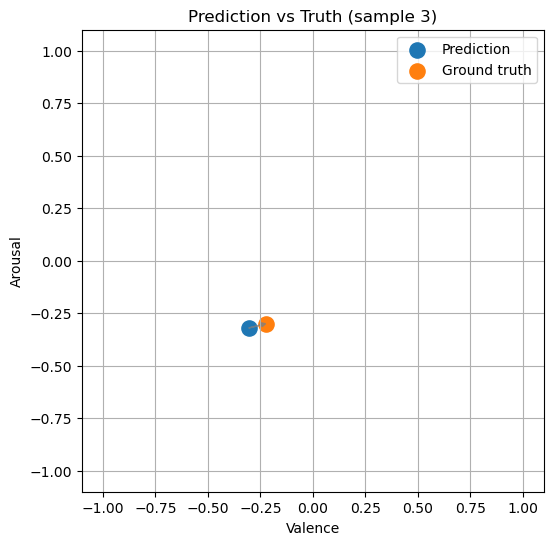

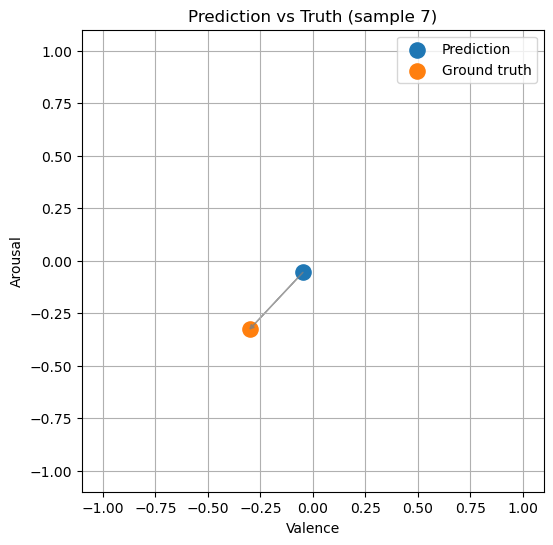

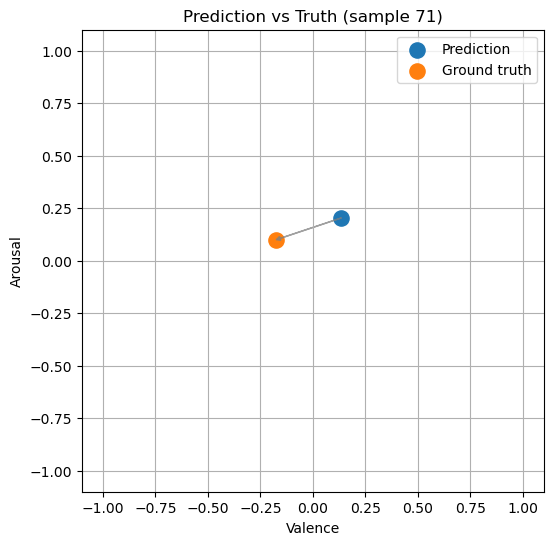

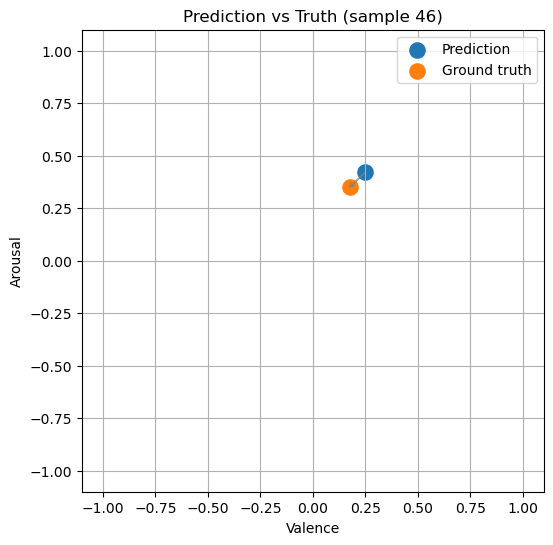

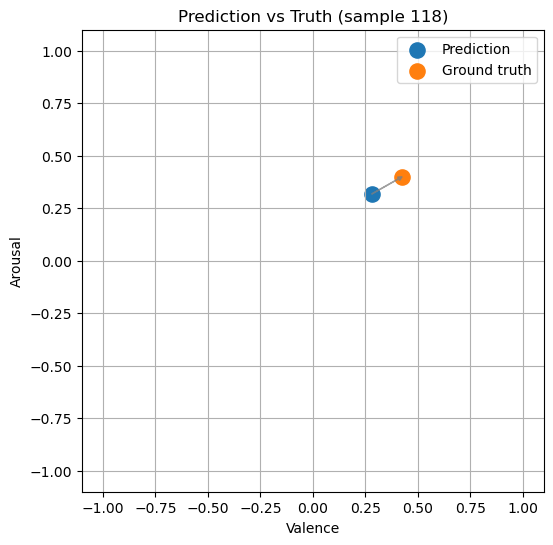

In [ ]:
v_predictions = two_results[11][12]["valence_pred"].detach().cpu().numpy()
v_truths = two_results[11][12]["valence_true"]

a_predictions = two_results[11][12]["arousal_pred"].detach().cpu().numpy()
a_truths = two_results[11][12]["arousal_true"]

mask = v_predictions.all() <= 1 and v_predictions.all() >= -1
print(mask)
mask = v_truths.all() <= 1 and v_truths.all() >= -1
print(mask)
mask = a_predictions.all() <= 1 and a_predictions.all() >= -1
print(mask)
mask = a_truths.all() <= 1 and a_truths.all() >= -1
print(mask)

idxs = set()
for i in range(5):
    idxs.add(random.randint(0, len(v_predictions)))

for idx in idxs:
    plot_predictions(idx, v_predictions, v_truths, a_predictions, a_truths)